In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
comb_df = train_df.append(test_df)
members_df = pd.read_csv('data/members.csv')
songs_df = pd.read_csv('data/songs.csv')
song_extra_info_df = pd.read_csv('data/song_extra_info.csv')

songs_df = songs_df.merge(song_extra_info_df, on='song_id', how='left')

train_df = train_df.merge(songs_df, on='song_id', how='left')
test_df = test_df.merge(songs_df, on='song_id', how='left')

train_df = train_df.merge(members_df, on='msno', how='left')
test_df = test_df.merge(members_df, on='msno', how='left')

# fill missing data to visualize
train_df.fillna('nan', inplace=True)
test_df.fillna('nan', inplace=True)

<a id='chapter_song'></a>
# Songs

## song_length

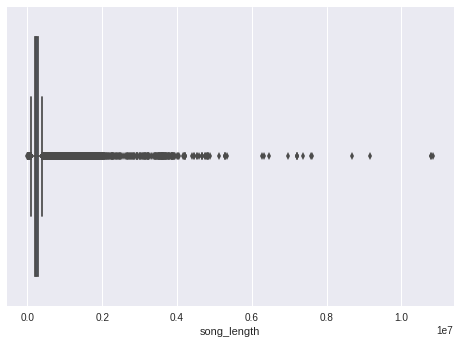

count      359914
mean       248419
std        146699
min          1393
25%        198217
50%        233732
75%        274746
max      10851706
Name: song_length, dtype: int64

In [3]:
song_length_unique_df = train_df[['song_id', 'song_length']].drop_duplicates('song_id')

song_length_unique_series = song_length_unique_df['song_length'].astype(np.float64)

# assert(song_length_unique_series.duplicates())
# print(song_length_unique_df)
sns.boxplot(x=song_length_unique_series)
sns.plt.show()

song_length_unique_series.describe().astype(np.int64)

It seems that there exists outliers.
Now we treat them as outliers and so drop them.

In [4]:
song_length_unique_series = song_length_unique_series[np.abs(song_length_unique_series-song_length_unique_series.mean()) <= (3 * song_length_unique_series.std())]
song_length_unique_series.describe().astype(np.int64)

count    356821
mean     239738
std       78559
min        1393
25%      197903
50%      233128
75%      273438
max      688363
Name: song_length, dtype: int64

Notice that there exists very long song were played by users.

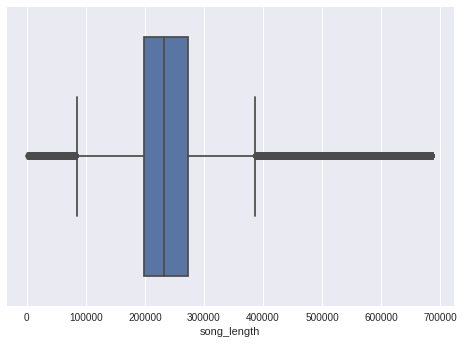

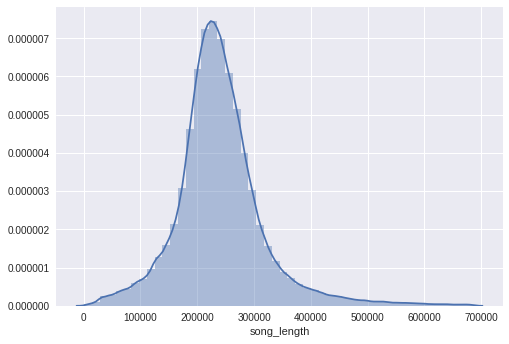

In [5]:
sns.boxplot(song_length_unique_series)
sns.plt.show()

sns.distplot(song_length_unique_series)
sns.plt.show()

It seems the distribution is almost normal after removing outliers.

### more on song_length

1393.0 10851706.0


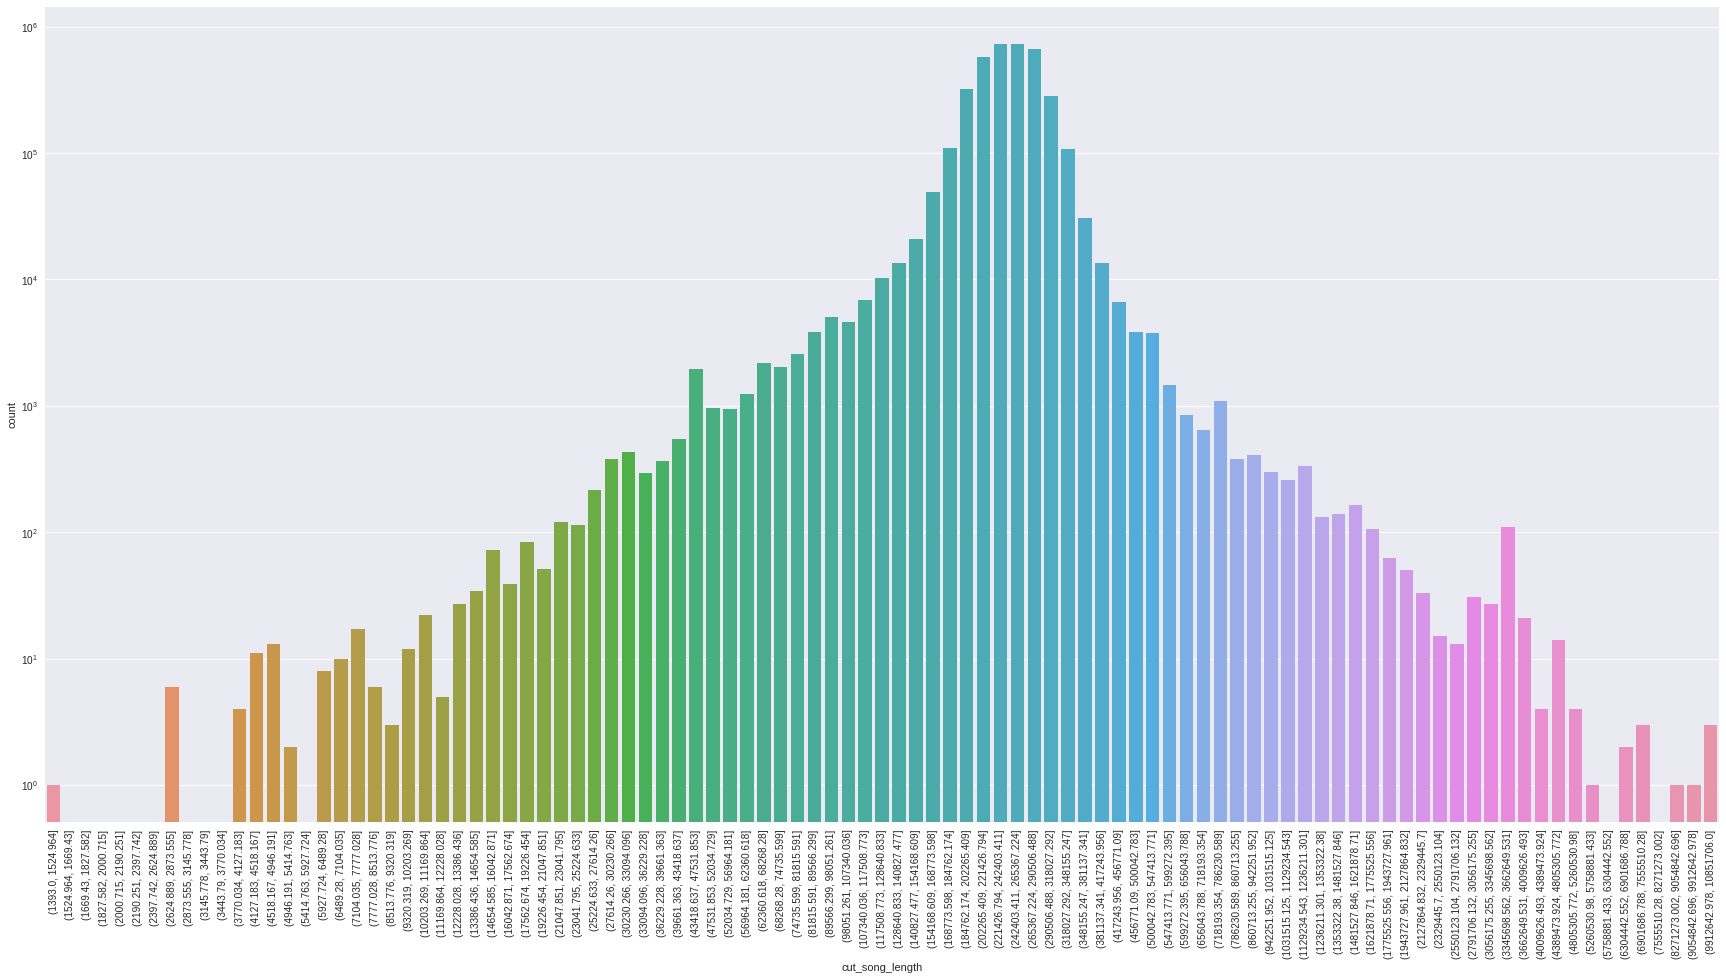

In [6]:
count_df = train_df[['song_length', 'target']]
count_df = count_df[count_df['target'] == 1]


# transform scale unit into "log10"
count_df['song_length'] = count_df['song_length'].astype(np.float64)
print(count_df['song_length'].min(), count_df['song_length'].max())
length_bins = np.logspace(np.log10(count_df['song_length'].min()), np.log10(count_df['song_length'].max()), 100)

# ignore missing data
count_df['song_length'].fillna(0.0, inplace=True)

count_df['cut_song_length'] = pd.cut(count_df['song_length'], bins=length_bins)
count_df.head(10)

sns.plt.figure(figsize=(30, 15)) 
sns.plt.xticks(rotation=90)
g = sns.countplot(x='cut_song_length', data=count_df)
g.set_yscale('log')
sns.plt.show()

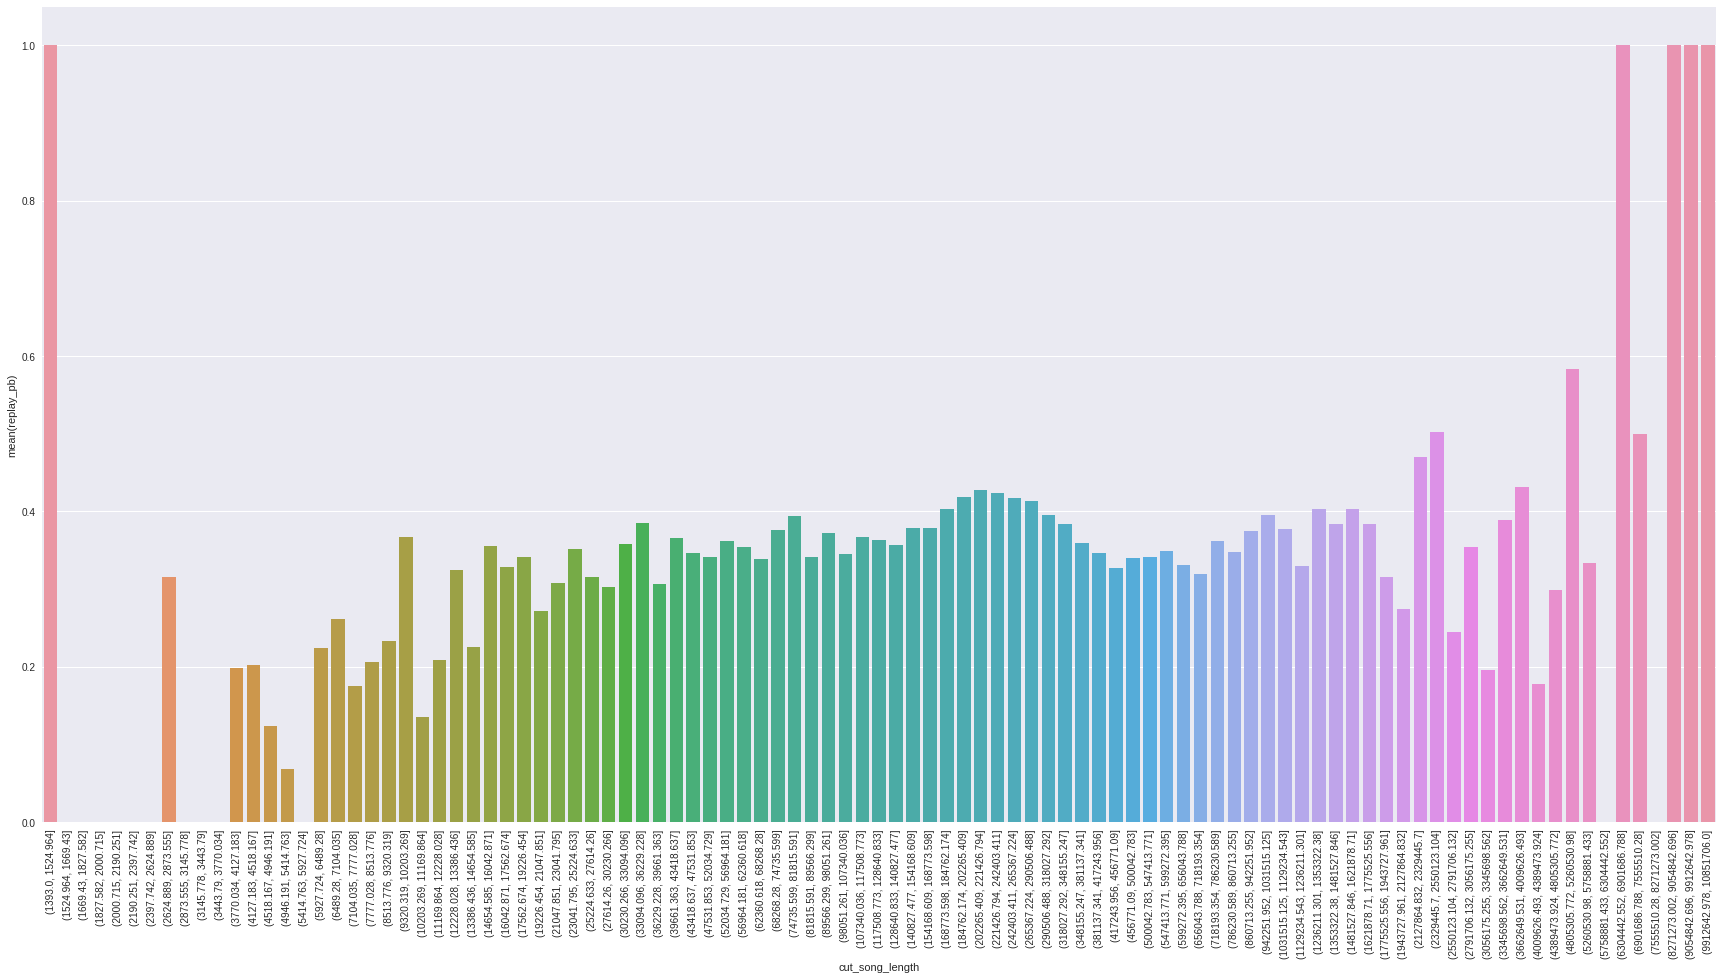

In [7]:
count_df = train_df[['song_length', 'target']].groupby('song_length').agg('mean')
count_df.reset_index(inplace=True)
count_df.columns = ['song_length', 'replay_pb']

# transform scale unit into "log10"
count_df['song_length'] = count_df['song_length'].astype(np.float64)
length_bins = np.logspace(np.log10(count_df['song_length'].min()), np.log10(count_df['song_length'].max()), 100)
count_df['song_length'].fillna(0.0, inplace=True)

count_df['cut_song_length'] = pd.cut(count_df['song_length'], bins=length_bins)


count_df = count_df[['cut_song_length', 'replay_pb']].groupby('cut_song_length').agg('mean')
count_df.reset_index(inplace=True)
count_df.head(10)

sns.plt.figure(figsize=(30, 15)) 
sns.plt.xticks(rotation=90)
sns.barplot(y='replay_pb', x='cut_song_length', data=count_df)
sns.plt.show()

The songs whose song length larger than average one (248419 ms) have larger chance for replaying.
Maybe the longer songs are played from small users; but these users really like them.
也就是說，冷門的歌曲更會被其歌迷追蹤。

In [8]:
song_genre_ids_series = train_df['genre_ids']
# print(list(song_genre_ids_series))

There are missing data and all seperators are only '|' sign.

In [20]:
def parse_splitted_category_to_number(x):
    if x is np.nan:
        return 0
    
    x = str(x)
    x.replace('/', '|')
    x.replace(';', '|')
    x.replace('\\', '|')
    x.replace('&', '|')
    return x.count('|') + 1


train_df['genre_count'] = train_df['genre_ids'].apply(parse_splitted_category_to_number)
genre_df = train_df[['song_id', 'genre_ids', 'genre_count', 'target']]

genre_df.head(10)

,song_id,genre_ids,genre_count,target
0,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,359,1,1
1,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,1259,1,1
2,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,1259,1,1
3,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,1019,1,1
4,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1011,1,1
5,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,1259,1,1
6,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,465,1,1
7,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,1011,1,1
8,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,2022,1,1
9,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,465,1,1


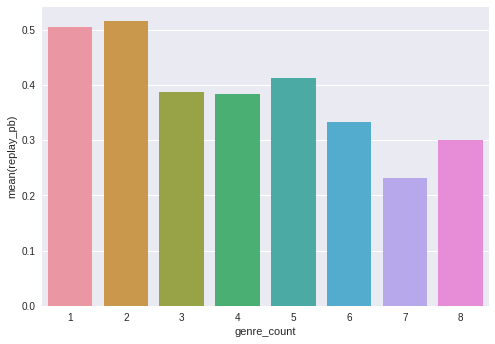

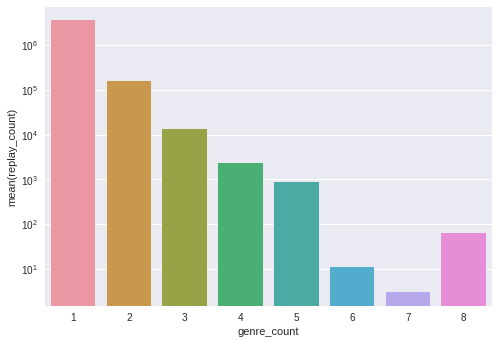

,genre_count,replay_pb,play_count,replay_count
0,1,0.503714,7037101,3544685
1,2,0.515374,298160,153664
2,3,0.386646,33682,13023
3,4,0.382546,6096,2332
4,5,0.411792,2120,873
5,6,0.333333,33,11
6,7,0.230769,13,3
7,8,0.300469,213,64


In [26]:
count_df = genre_df[['genre_count', 'target']].groupby('genre_count').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['genre_count', 'replay_pb', 'play_count']

count_df['replay_count'] = (count_df['replay_pb'] * count_df['play_count']).astype(np.int32)

sns.barplot(x='genre_count', y='replay_pb', data=count_df)
sns.plt.show()

g = sns.barplot(x='genre_count', y='replay_count', data=count_df)
g.set_yscale('log')
sns.plt.show()
count_df

**genre_ids** having 1 or 2 category is more chance to replay than more than 2 categories.
Replayed songs labeled single genre are more than others.

573


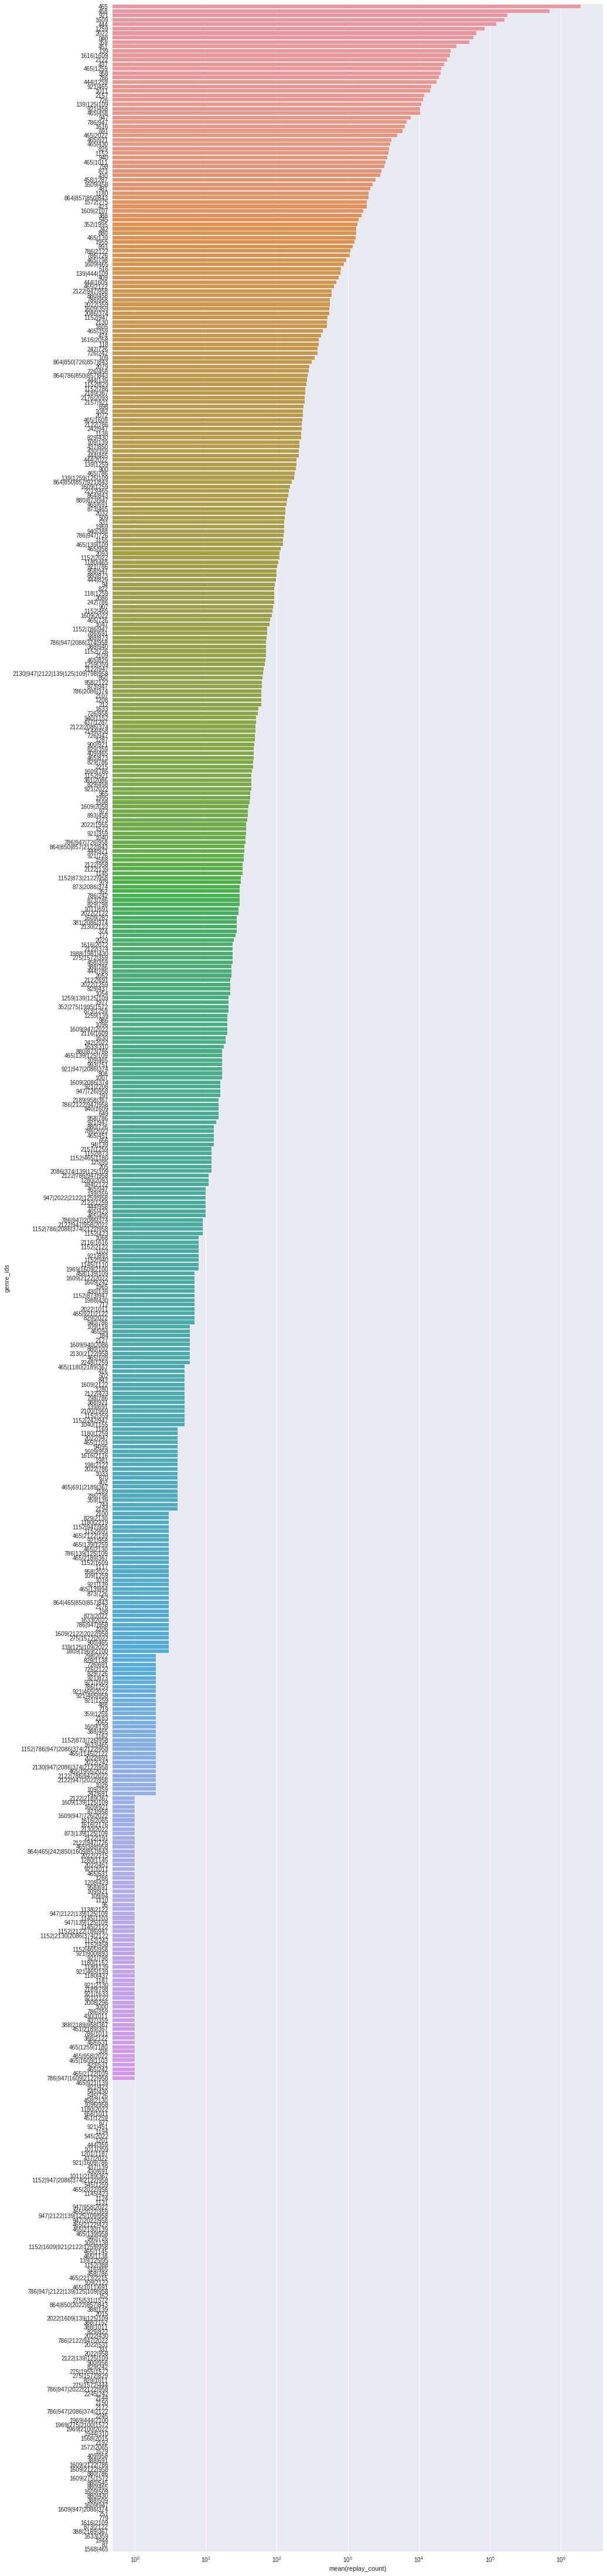

In [46]:
count_df = genre_df[['genre_ids', 'target']].groupby('genre_ids').agg(['mean', 'count'])
count_df.reset_index(inplace=True)
count_df.columns = ['genre_ids', 'replay_pb', 'play_count']
print(len(count_df))

count_df['replay_count'] = (count_df['replay_pb'] * count_df['play_count']).astype(np.int32)
count_df = count_df.sort_values(by=['replay_count'], ascending=False)

sns.plt.figure(figsize=(15, 80))
g = sns.barplot(y='genre_ids', x='replay_count', data=count_df)
g.set_xscale('log')
sns.plt.show()

There are total **573** combinations in *genre_ids*.
Notice that *genre 465* is the most popular; however, there is *genre 1568|465* which is the most unpopular where they both contain *genre 465*.
Hence, we can not decompose composite genres into several separate genres for consideration.